In [1]:
from lib.data_util import *
from lib.documentation import *
from lib.data_models import *
import polars as pl
import seaborn as sns

### Pre-process data

In [2]:
df = read_data("data/statcast_pitch_swing_data_20240402_20240630.arrow")
build_description_table(df, "glossary/data_definitions.md", "glossary/data_dictionary.md", build_plots=True)

In [ ]:
pitcher_lookup = player_lookup(df, "pitcher", Pitcher)
batter_lookup = player_lookup(df, "batter", Batter)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, 'FF'),
  Text(1, 0, 'CH'),
  Text(2, 0, 'SI'),
  Text(3, 0, 'KC'),
  Text(4, 0, 'SL'),
  Text(5, 0, 'ST'),
  Text(6, 0, 'FC'),
  Text(7, 0, 'CU'),
  Text(8, 0, 'SV'),
  Text(9, 0, 'FS'),
  Text(10, 0, 'PO'),
  Text(11, 0, 'FO'),
  Text(12, 0, 'FA'),
  Text(13, 0, 'KN'),
  Text(14, 0, 'EP'),
  Text(15, 0, 'CS'),
  Text(16, 0, '')])

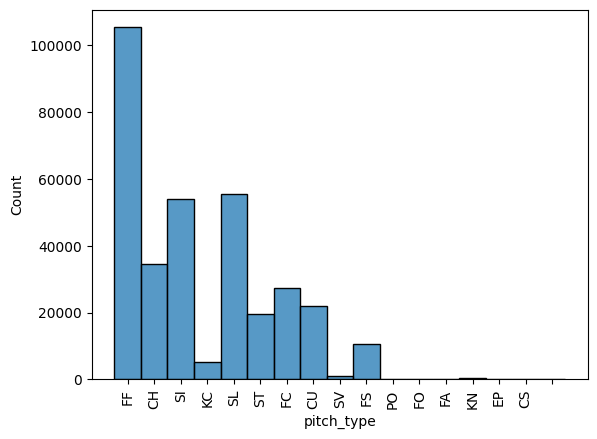

In [ ]:
sns.histplot(data=df, x="pitch_type")

### Is Swing Rate related to Contact Percentage

<Axes: xlabel='swing_percentage', ylabel='hit_into_play_percentage'>

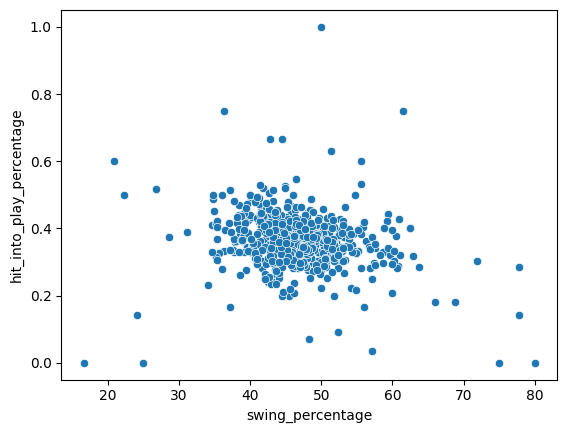

In [ ]:
df.group_by("batter")
sns.scatterplot(data=(df.group_by("batter").agg([
  (pl.col("swing_event").mean()*100).alias("swing_percentage"),
  (pl.col("description").eq("hit_into_play").sum() / (pl.col("swing_event").sum())).alias("hit_into_play_percentage")
])), x="swing_percentage", y="hit_into_play_percentage")

There does not appear to be a strong relationship between the percentage of balls that a player swings at, and the percentage of balls that a player hits into play.

### What does a batter's swing profile look like?

#### Drop the batters with very low swing counts

In [ ]:
batter_profile_df = df.filter(pl.col("swing_event")).group_by("batter").agg([
  pl.col("bat_speed").min().alias("bat_speed_min"),
  pl.col("bat_speed").max().alias("bat_speed_max"),
  pl.col("bat_speed").mean().alias("mean_bat_speed"),
  pl.col("swing_length").min().alias("swing_length_min"),
  pl.col("swing_length").max().alias("swing_length_max"),
  pl.col("swing_length").mean().alias("swing_length_mean"),
  pl.col("swing_event").count().alias("swing_count")
]).filter(pl.col("swing_count") > 30)

In [ ]:
df.join(batter_profile_df, on="batter", how="inner").group_by(["pitcher", "pitch_type"])

pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,zone,des,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,fielder_2,vx0,vy0,vz0,…,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,swing_event,bat_speed_min,bat_speed_max,mean_bat_speed,swing_length_min,swing_length_max,swing_length_mean,swing_count
cat,date,f64,f64,f64,cat,u32,u32,cat,cat,u8,str,cat,cat,cat,cat,cat,u8,cat,u8,u8,f64,f64,f64,f64,u32,u32,u32,u8,u8,cat,f64,f64,u32,f64,f64,f64,…,u32,u32,u32,f64,f64,f64,f64,u8,u8,u8,u8,u8,u8,cat,u8,u8,u8,u8,u8,u8,u8,u8,cat,cat,u16,f64,f64,f64,f64,bool,f64,f64,f64,f64,f64,f64,u32
"""SI""",2024-04-02,95.0,-2.02,5.12,"""Rocchio, Brayan""",677587,622491,"""""","""called_strike""",2,"""Brayan Rocchio singles on a po…","""L""","""R""","""SEA""","""CLE""","""S""",null,"""""",0,0,-1.48,0.15,-0.14,3.15,null,null,666310,2,6,"""Top""",null,null,663728,8.099205,-138.195334,0.123694,…,686527,677594,571745,55.04,null,null,null,null,null,null,null,46,1,"""Sinker""",0,4,4,0,4,0,4,0,"""Standard""","""Standard""",238,0.0,-0.042,null,null,false,3.926271,82.977541,66.697631,0.47298,8.74293,7.014165,411
"""SI""",2024-04-02,90.7,-1.26,5.13,"""Ohtani, Shohei""",660271,657277,"""walk""","""ball""",11,"""Shohei Ohtani walks. Enrique…","""L""","""R""","""LAD""","""SF""","""B""",null,"""""",3,0,-1.45,0.09,-2.25,3.29,null,null,571771,2,4,"""Bot""",null,null,672275,0.6209,-132.024381,1.22685,…,624424,808982,573262,53.68,null,0.691353,0.7,1,0,0,null,37,4,"""Sinker""",5,2,5,2,2,5,5,2,"""Infield shade""","""Standard""",234,0.009,0.082,null,null,false,35.759187,86.636715,74.12188,4.92601,9.49791,7.629199,598
"""SI""",2024-04-02,91.8,1.75,4.89,"""Casas, Triston""",671213,622072,"""walk""","""ball""",11,"""Triston Casas walks.""","""L""","""L""","""OAK""","""BOS""","""B""",null,"""""",3,2,0.93,1.04,-2.09,2.97,null,null,null,0,6,"""Top""",null,null,669127,-11.658589,-133.059239,-1.161628,…,664913,668709,671732,54.29,null,0.691353,0.7,1,0,0,null,46,8,"""Sinker""",4,3,3,4,3,4,3,4,"""Infield shade""","""Standard""",122,-0.06,0.343,null,null,false,21.707263,85.392952,72.642678,5.12904,9.09333,7.688442,102
"""FF""",2024-04-02,93.4,-3.17,5.63,"""Rizzo, Anthony""",519203,668678,"""""","""ball""",13,"""Anthony Rizzo grounds out soft…","""L""","""R""","""AZ""","""NYY""","""B""",null,"""""",2,2,-0.59,1.49,-1.0,1.17,null,null,665742,2,6,"""Top""",null,null,672515,6.960234,-135.680334,-9.133126,…,666971,678489,664983,53.5,null,null,null,null,null,null,null,45,5,"""4-Seam Fastball""",3,0,0,3,0,3,0,3,"""Infield shade""","""Standard""",209,0.0,0.081,null,null,false,28.210533,82.236655,66.940149,3.92761,8.62441,6.692013,453
"""SI""",2024-04-02,89.9,-1.14,5.01,"""Ohtani, Shohei""",660271,657277,"""""","""ball""",12,"""Shohei Ohtani walks. Enrique…","""L""","""R""","""LAD""","""SF""","""B""",null,"""""",2,0,-1.45,0.07,1.31,2.92,null,null,571771,2,4,"""Bot""",null,null,672275,9.300755,-130.558245,0.791115,…,624424,808982,573262,53.36,null,null,null,null,null,null,null,37,3,"""Sinker""",5,2,5,2,2,5,5,2,"""Standard""","""Standard""",243,0.0,0.079,null,null,false,35.759187,86.636715,74.12188,4.92601,9.49791,7.629199,598
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SL""",2024-06-30,85.9,1.63,5.68,"""Cave, Jake""",595909,694363,"""""","""called_strike""",4,"""Jake Cave grounds out, second …","""L""","""L""","""CWS""","""COL""","""S""",null,"""""",0,